/home/james/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Size of:
- Training-set:		37882
- Validation-set:	6262


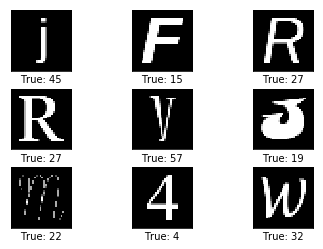

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu May 24 00:21:41 2018

@author: aditya.sharma
"""

# In[1]:


import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import random

tf.__version__


# ### *Step 1:* Loading data
# The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

# In[2]:


class DataSet(object):

    def __init__(self, images, labels, img_names, cls):
        self._num_examples = images.shape[0]

        self._images = images
        self._labels = labels
        self._img_names = img_names
        self._index_in_epoch = 0
        self._epochs_done = 0
        self._cls = cls

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def img_names(self):
        return self._img_names

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples

    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            # After each epoch we update this
            self._epochs_done += 1
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end], self._img_names[start:end], self._cls[start:end]
    

def load_data(input_path, dataset_type, image_size):
    images = []
    labels = []
    img_names = []
    cls = []
    
    data_path = os.path.join(input_path, str(dataset_type+'-set'))
    label_path = os.path.join(input_path, str(dataset_type+'.txt'))
    with open(label_path, 'r') as label_file:
        lines = label_file.readlines()
        random.shuffle(lines)
        for line in lines:
            filename, index = line.split(' ')
            label = np.zeros(62)
            label[int(index)] = 1.0
            labels.append(label)
            
            
            img_names.append(filename)
            image_file_path = os.path.join(data_path, filename)
            image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (image_size, image_size),0,0, cv2.INTER_LINEAR)
            image = np.reshape(image, image_size*image_size)
            images.append(image)
            cls.append(int(index))
    images = np.array(images)
    labels = np.array(labels)
    img_names = np.array(img_names)
    cls = np.array(cls)

            
    return DataSet(images, labels, img_names, cls)
            

def read_train_sets(input_path, image_size):
    class DataSets(object):
        pass
    data_sets = DataSets()
    
    data_sets.train = load_data(input_path, 'train', image_size)
    data_sets.validation = load_data(input_path, 'vali', image_size)
    
    return data_sets
    
 
# In[3]: load data

input_path = '../Input/'
validation_size = 0.2
img_size = 32
num_channels = 1
num_classes = 62
batch_size = 64




data = read_train_sets(input_path, img_size)

# The MNIST data-set has now been loaded and consists of 70,000 images and associated labels (i.e. classifications of 
# the images). The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and 
# validation-sets in this tutorial.

# In[3]:


print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
#print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))


# The class-labels are One-Hot encoded, which means that each label is a vector with 10 elements, all of which are 
# zero except for one element. The index of this one element is the class-number, that is, the digit shown in the 
# associated image. We also need the class-numbers as integers for the validation-set, so we calculate it now.

# ### Helper-function for plotting images - MNIST

# In[4]:


def plot_images(images, cls_true, img_shape=None, cls_pred=None):
    assert len(images) == len(cls_true) == 9

    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape((img_size,img_size)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


images = data.validation.images[0:9]
cls_true = data.validation.cls[0:9]

plot_images(images=images, cls_true=cls_true)


img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 62
train_batch_size = 64

In [12]:
# Set parameters for CNN layers

convolution_params = {
    'layer_1a':{'fSize':3, 'fN':16, 'sSize':1, 'activation':'relu', 'channels':1},
    'layer_1b':{'fSize':5, 'fN':16, 'sSize':1, 'activation':'relu', 'channels':1},
    'layer_1c':{'fSize':7, 'fN':16, 'sSize':1, 'activation':'relu', 'channels':1},
    
    'layer_2a':{'fSize':3, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':48},
    'layer_2b':{'fSize':5, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':48},
    'layer_2c':{'fSize':7, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':48},
    
    'layer_3':{'fSize':5, 'fN':128, 'sSize':1, 'activation':'relu', 'channels':96},
    
    'layer_4':{'fSize':5, 'fN':256, 'sSize':1, 'activation':'relu', 'channels':128}
}

fc_params = {
    'layer_1':{'nodes':500,'dropout':0.1},
    'layer_2':{'nodes':500,'dropout':0.1}
}

regularization_coefficient = 0.01

def setup_graph(convolution_params, fc_params):
    y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='label')
    y_true_class = tf.argmax(y_true, axis=1)

    x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
    x_image = tf.reshape(x, [-1, img_size, img_size, 1])

    p = convolution_params['layer_1a']
    layer_conv1a, weights_conv1 = new_conv_layer(previous_layer=x_image, param_dic=p)
    p = convolution_params['layer_1b']
    layer_conv1b, weights_conv1 = new_conv_layer(previous_layer=x_image, param_dic=p)
    p = convolution_params['layer_1c']
    layer_conv1c, weights_conv1 = new_conv_layer(previous_layer=x_image, param_dic=p)
    layer_conv1 = tf.concat([layer_conv1a,layer_conv1b,layer_conv1c], 3)

    p = convolution_params['layer_2a']
    layer_conv2a, weights_conv2 = new_conv_layer(previous_layer=layer_conv1, param_dic=p) 
    p = convolution_params['layer_2b']
    layer_conv2b, weights_conv2 = new_conv_layer(previous_layer=layer_conv1, param_dic=p) 
    p = convolution_params['layer_2c']
    layer_conv2c, weights_conv2 = new_conv_layer(previous_layer=layer_conv1, param_dic=p) 
    layer_conv2 = tf.concat([layer_conv2a,layer_conv2b,layer_conv2c], 3)

    p = convolution_params['layer_3']
    layer_conv3, weights_conv3 = new_conv_layer(previous_layer=layer_conv2, param_dic=p) 

    p = convolution_params['layer_4']
    layer_conv4, weights_conv4 = new_conv_layer(previous_layer=layer_conv3, param_dic=p)


    layer_flat, num_features = flatten_layer(layer_conv4)

    p = fc_params['layer_1']
    layer_fc1, fc1_weights = new_fc_layer(input=layer_flat,
                             num_inputs=num_features,
                             num_outputs=p['nodes'],
                             use_relu=True)

    p = fc_params['layer_2']
    layer_fc2, fc2_weights = new_fc_layer(input=layer_fc1,
                             num_inputs=p['nodes'],
                             num_outputs=num_classes,
                             use_relu=False)


    y_hat = tf.nn.softmax(layer_fc2)
    y_hat_class = tf.argmax(y_hat, axis=1)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)

    cost = tf.reduce_mean(cross_entropy)
    regularizers = tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc2_weights)
    cost = tf.reduce_mean(cost + regularization_coefficient * regularizers)
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
    correct_prediction = tf.equal(y_hat_class, y_true_class)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [2]:
activation_dictionary = {'relu':tf.nn.relu,'lrelu':tf.nn.leaky_relu,'tanh':tf.nn.tanh,'sigmoid':tf.nn.sigmoid}

def new_weights(shape):
    new_weight = tf.truncated_normal(shape, stddev=0.05)
    return tf.Variable(new_weight)

def new_biases(length):
    new_bias = tf.constant(0.05, shape=[length])
    return tf.Variable(new_bias)

def new_conv_layer(previous_layer,param_dic):
    p = param_dic
    weights = new_weights(shape=[p['fSize'], p['fSize'], p['channels'], p['fN']])
    biases = new_biases(length=p['fN'])
    
    layer = tf.nn.conv2d(input=previous_layer,
                         filter=weights,
                         strides=[1, p['sSize'], p['sSize'], 1],
                         padding='SAME')

    layer += biases
    layer = tf.nn.max_pool(value=layer,
                           ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           padding='SAME')
    
    activation = activation_dictionary[p['activation']]
    output = activation(layer)
    return output, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features


def new_fc_layer(input, num_inputs, num_outputs, use_relu=True, dropout=0.05): 
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
    layer = tf.nn.dropout(layer, 1-dropout)
    return layer, weights


# Set parameters for CNN layers

convolution_params = {
    'layer_1a':{'fSize':3, 'fN':16, 'sSize':1, 'activation':'relu', 'channels':1},
    'layer_1b':{'fSize':5, 'fN':16, 'sSize':1, 'activation':'relu', 'channels':1},
    'layer_1c':{'fSize':7, 'fN':16, 'sSize':1, 'activation':'relu', 'channels':1},
    
    'layer_2a':{'fSize':3, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':48},
    'layer_2b':{'fSize':5, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':48},
    'layer_2c':{'fSize':7, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':48},
    
    'layer_3':{'fSize':5, 'fN':128, 'sSize':1, 'activation':'relu', 'channels':96},
    
    'layer_4':{'fSize':5, 'fN':256, 'sSize':1, 'activation':'relu', 'channels':128}
}

fc_params = {
    'layer_1':{'nodes':500,'dropout':0.1},
    'layer_2':{'nodes':500,'dropout':0.1}
}

regularization_coefficient = 0.01



y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='label')
y_true_class = tf.argmax(y_true, axis=1)

x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, 1])

p = convolution_params['layer_1a']
layer_conv1a, weights_conv1 = new_conv_layer(previous_layer=x_image, param_dic=p)
p = convolution_params['layer_1b']
layer_conv1b, weights_conv1 = new_conv_layer(previous_layer=x_image, param_dic=p)
p = convolution_params['layer_1c']
layer_conv1c, weights_conv1 = new_conv_layer(previous_layer=x_image, param_dic=p)
layer_conv1 = tf.concat([layer_conv1a,layer_conv1b,layer_conv1c], 3)

p = convolution_params['layer_2a']
layer_conv2a, weights_conv2 = new_conv_layer(previous_layer=layer_conv1, param_dic=p) 
p = convolution_params['layer_2b']
layer_conv2b, weights_conv2 = new_conv_layer(previous_layer=layer_conv1, param_dic=p) 
p = convolution_params['layer_2c']
layer_conv2c, weights_conv2 = new_conv_layer(previous_layer=layer_conv1, param_dic=p) 
layer_conv2 = tf.concat([layer_conv2a,layer_conv2b,layer_conv2c], 3)

p = convolution_params['layer_3']
layer_conv3, weights_conv3 = new_conv_layer(previous_layer=layer_conv2, param_dic=p) 

p = convolution_params['layer_4']
layer_conv4, weights_conv4 = new_conv_layer(previous_layer=layer_conv3, param_dic=p)


layer_flat, num_features = flatten_layer(layer_conv4)

p = fc_params['layer_1']
layer_fc1, fc1_weights = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=p['nodes'],
                         use_relu=True)

p = fc_params['layer_2']
layer_fc2, fc2_weights = new_fc_layer(input=layer_fc1,
                         num_inputs=p['nodes'],
                         num_outputs=num_classes,
                         use_relu=False)


y_hat = tf.nn.softmax(layer_fc2)
y_hat_class = tf.argmax(y_hat, axis=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)

cost = tf.reduce_mean(cross_entropy)
regularizers = tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc2_weights)
cost = tf.reduce_mean(cost + regularization_coefficient * regularizers)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_hat_class, y_true_class)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [3]:


def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    global train_scores

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _, _ = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            train_scores.append(acc)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))



def print_validation_accuracy():

    # Number of images in the validation-set.
    num_validation = len(data.validation.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_validation, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_validation:
        # The ending index for the next batch is denoted j.
        j = min(i + validation_batch_size, num_validation)

        # Get the images from the validation-set between index i and j.
        images = data.validation.images[i:j, :]

        # Get the associated labels.
        labels = data.validation.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_hat_class, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the validation-set.
    cls_true = data.validation.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the validation-set.
    acc = float(correct_sum) / num_validation

    # Print the accuracy.
    msg = "Accuracy on validation-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_validation))



In [4]:
np.random.seed(10)
# Split the validation-set into smaller batches of this size.
validation_batch_size = 256
# Counter for total number of iterations performed so far.
total_iterations = 0
train_scores = []

# ## Performance after 10,000 optimization iterations
# 
# After 10,000 optimization iterations, the model has a classification accuracy on the validation-set of about 99%.

# In[ ]:

session = tf.Session()
session.run(tf.global_variables_initializer())

optimize(num_iterations=1501) # We performed 1000 iterations above.

print_validation_accuracy()

Optimization Iteration:      1, Training Accuracy:   1.6%
Optimization Iteration:    101, Training Accuracy:  15.6%
Optimization Iteration:    201, Training Accuracy:  28.1%
Optimization Iteration:    301, Training Accuracy:  23.4%
Optimization Iteration:    401, Training Accuracy:  53.1%
Optimization Iteration:    501, Training Accuracy:  48.4%
Optimization Iteration:    601, Training Accuracy:  54.7%
Optimization Iteration:    701, Training Accuracy:  56.2%
Optimization Iteration:    801, Training Accuracy:  51.6%
Optimization Iteration:    901, Training Accuracy:  64.1%
Optimization Iteration:   1001, Training Accuracy:  62.5%
Optimization Iteration:   1101, Training Accuracy:  57.8%
Optimization Iteration:   1201, Training Accuracy:  67.2%
Optimization Iteration:   1301, Training Accuracy:  71.9%
Optimization Iteration:   1401, Training Accuracy:  65.6%
Optimization Iteration:   1501, Training Accuracy:  64.1%
Time usage: 0:07:47
Accuracy on validation-Set: 66.1% (4137 / 6262)


In [7]:
np.random.seed(10)
# Split the validation-set into smaller batches of this size.
validation_batch_size = 256
# Counter for total number of iterations performed so far.
total_iterations = 0
train_scores = []

# ## Performance after 10,000 optimization iterations
# 
# After 10,000 optimization iterations, the model has a classification accuracy on the validation-set of about 99%.

# In[ ]:

session = tf.Session()
session.run(tf.global_variables_initializer())

optimize(num_iterations=2501) # We performed 1000 iterations above.

print_validation_accuracy()

Optimization Iteration:      1, Training Accuracy:   0.0%
Optimization Iteration:    101, Training Accuracy:  21.9%
Optimization Iteration:    201, Training Accuracy:  28.1%
Optimization Iteration:    301, Training Accuracy:  43.8%
Optimization Iteration:    401, Training Accuracy:  40.6%
Optimization Iteration:    501, Training Accuracy:  46.9%
Optimization Iteration:    601, Training Accuracy:  46.9%
Optimization Iteration:    701, Training Accuracy:  60.9%
Optimization Iteration:    801, Training Accuracy:  68.8%
Optimization Iteration:    901, Training Accuracy:  68.8%
Optimization Iteration:   1001, Training Accuracy:  73.4%
Optimization Iteration:   1101, Training Accuracy:  60.9%
Optimization Iteration:   1201, Training Accuracy:  65.6%
Optimization Iteration:   1301, Training Accuracy:  81.2%
Optimization Iteration:   1401, Training Accuracy:  73.4%
Optimization Iteration:   1501, Training Accuracy:  75.0%
Optimization Iteration:   1601, Training Accuracy:  73.4%
Optimization I

In [20]:
convolution_params = {
    'layer_1a':{'fSize':3, 'fN':16, 'sSize':1, 'activation':'relu', 'channels':1},
    'layer_1b':{'fSize':5, 'fN':16, 'sSize':1, 'activation':'relu', 'channels':1},
    'layer_1c':{'fSize':7, 'fN':16, 'sSize':1, 'activation':'relu', 'channels':1},
    
    'layer_2a':{'fSize':3, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':48},
    'layer_2b':{'fSize':5, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':48},
    'layer_2c':{'fSize':7, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':48},
    
    'layer_3':{'fSize':5, 'fN':128, 'sSize':1, 'activation':'relu', 'channels':96},
    
    'layer_4':{'fSize':5, 'fN':256, 'sSize':1, 'activation':'relu', 'channels':128}
}

fc_params = {
    'layer_1':{'nodes':500,'dropout':0.1},
    'layer_2':{'nodes':500,'dropout':0.1}
}

np.random.seed(10)
# Split the validation-set into smaller batches of this size.
validation_batch_size = 256
# Counter for total number of iterations performed so far.


total_iterations = 0
train_scores = []

setup_graph(convolution_params,fc_params)
session = tf.Session()
session.run(tf.global_variables_initializer())

optimize(num_iterations=20001) # We performed 1000 iterations above.
print_validation_accuracy()

Optimization Iteration:      1, Training Accuracy:   3.1%
Optimization Iteration:    101, Training Accuracy:  14.1%
Optimization Iteration:    201, Training Accuracy:  23.4%
Optimization Iteration:    301, Training Accuracy:  25.0%
Optimization Iteration:    401, Training Accuracy:  39.1%
Optimization Iteration:    501, Training Accuracy:  50.0%
Optimization Iteration:    601, Training Accuracy:  45.3%
Optimization Iteration:    701, Training Accuracy:  59.4%
Optimization Iteration:    801, Training Accuracy:  62.5%
Optimization Iteration:    901, Training Accuracy:  67.2%
Optimization Iteration:   1001, Training Accuracy:  62.5%
Optimization Iteration:   1101, Training Accuracy:  65.6%
Optimization Iteration:   1201, Training Accuracy:  65.6%
Optimization Iteration:   1301, Training Accuracy:  70.3%
Optimization Iteration:   1401, Training Accuracy:  65.6%
Optimization Iteration:   1501, Training Accuracy:  71.9%
Optimization Iteration:   1601, Training Accuracy:  75.0%
Optimization I

In [21]:
convolution_params = {
    'layer_1a':{'fSize':3, 'fN':16, 'sSize':1, 'activation':'relu', 'channels':1},
    'layer_1b':{'fSize':5, 'fN':16, 'sSize':1, 'activation':'relu', 'channels':1},
    'layer_1c':{'fSize':7, 'fN':16, 'sSize':1, 'activation':'relu', 'channels':1},
    
    'layer_2a':{'fSize':3, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':48},
    'layer_2b':{'fSize':5, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':48},
    'layer_2c':{'fSize':7, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':48},
    
    'layer_3':{'fSize':5, 'fN':128, 'sSize':1, 'activation':'relu', 'channels':96},
    
    'layer_4':{'fSize':5, 'fN':256, 'sSize':1, 'activation':'relu', 'channels':128}
}

fc_params = {
    'layer_1':{'nodes':500,'dropout':0.2},
    'layer_2':{'nodes':500,'dropout':0.2}
}

np.random.seed(10)
# Split the validation-set into smaller batches of this size.
validation_batch_size = 256
# Counter for total number of iterations performed so far.


total_iterations = 0
train_scores = []

setup_graph(convolution_params,fc_params)
session = tf.Session()
session.run(tf.global_variables_initializer())

optimize(num_iterations=20001) # We performed 1000 iterations above.
print_validation_accuracy()

Optimization Iteration:      1, Training Accuracy:   0.0%
Optimization Iteration:    101, Training Accuracy:  21.9%
Optimization Iteration:    201, Training Accuracy:  34.4%
Optimization Iteration:    301, Training Accuracy:  34.4%
Optimization Iteration:    401, Training Accuracy:  34.4%
Optimization Iteration:    501, Training Accuracy:  46.9%
Optimization Iteration:    601, Training Accuracy:  67.2%
Optimization Iteration:    701, Training Accuracy:  51.6%
Optimization Iteration:    801, Training Accuracy:  45.3%
Optimization Iteration:    901, Training Accuracy:  60.9%
Optimization Iteration:   1001, Training Accuracy:  65.6%
Optimization Iteration:   1101, Training Accuracy:  60.9%
Optimization Iteration:   1201, Training Accuracy:  65.6%
Optimization Iteration:   1301, Training Accuracy:  62.5%
Optimization Iteration:   1401, Training Accuracy:  76.6%
Optimization Iteration:   1501, Training Accuracy:  68.8%
Optimization Iteration:   1601, Training Accuracy:  82.8%
Optimization I

In [14]:
convolution_params = {
    'layer_1a':{'fSize':5, 'fN':16, 'sSize':1, 'activation':'relu', 'channels':1},
    'layer_1b':{'fSize':5, 'fN':16, 'sSize':1, 'activation':'relu', 'channels':1},
    'layer_1c':{'fSize':5, 'fN':16, 'sSize':1, 'activation':'relu', 'channels':1},
    
    'layer_2a':{'fSize':5, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':48},
    'layer_2b':{'fSize':5, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':48},
    'layer_2c':{'fSize':5, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':48},
    
    'layer_3':{'fSize':5, 'fN':128, 'sSize':1, 'activation':'relu', 'channels':96},
    
    'layer_4':{'fSize':5, 'fN':256, 'sSize':1, 'activation':'relu', 'channels':128}
}

fc_params = {
    'layer_1':{'nodes':500,'dropout':0.1},
    'layer_2':{'nodes':500,'dropout':0.1}
}

np.random.seed(10)
# Split the validation-set into smaller batches of this size.
validation_batch_size = 256
# Counter for total number of iterations performed so far.


total_iterations = 0
train_scores = []

setup_graph(convolution_params,fc_params)
session = tf.Session()
session.run(tf.global_variables_initializer())

optimize(num_iterations=10001) # We performed 1000 iterations above.
print_validation_accuracy()

Optimization Iteration:      1, Training Accuracy:   1.6%
Optimization Iteration:    101, Training Accuracy:  21.9%
Optimization Iteration:    201, Training Accuracy:  32.8%
Optimization Iteration:    301, Training Accuracy:  32.8%
Optimization Iteration:    401, Training Accuracy:  42.2%
Optimization Iteration:    501, Training Accuracy:  50.0%
Optimization Iteration:    601, Training Accuracy:  50.0%
Optimization Iteration:    701, Training Accuracy:  50.0%
Optimization Iteration:    801, Training Accuracy:  64.1%
Optimization Iteration:    901, Training Accuracy:  64.1%
Optimization Iteration:   1001, Training Accuracy:  67.2%
Optimization Iteration:   1101, Training Accuracy:  75.0%
Optimization Iteration:   1201, Training Accuracy:  65.6%
Optimization Iteration:   1301, Training Accuracy:  68.8%
Optimization Iteration:   1401, Training Accuracy:  68.8%
Optimization Iteration:   1501, Training Accuracy:  70.3%
Optimization Iteration:   1601, Training Accuracy:  76.6%
Optimization I

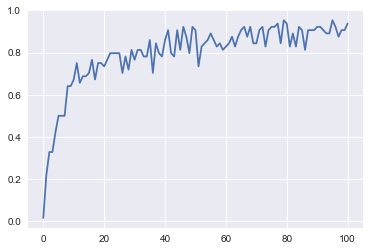

In [15]:
plt.plot(train_scores)

Optimization Iteration:      1, Training Accuracy:   6.2%
Optimization Iteration:    101, Training Accuracy:  12.5%
Optimization Iteration:    201, Training Accuracy:  17.2%
Optimization Iteration:    301, Training Accuracy:  39.1%
Optimization Iteration:    401, Training Accuracy:  42.2%
Optimization Iteration:    501, Training Accuracy:  48.4%
Optimization Iteration:    601, Training Accuracy:  40.6%
Optimization Iteration:    701, Training Accuracy:  60.9%
Optimization Iteration:    801, Training Accuracy:  68.8%
Optimization Iteration:    901, Training Accuracy:  57.8%
Optimization Iteration:   1001, Training Accuracy:  71.9%
Optimization Iteration:   1101, Training Accuracy:  62.5%
Optimization Iteration:   1201, Training Accuracy:  67.2%
Optimization Iteration:   1301, Training Accuracy:  68.8%
Optimization Iteration:   1401, Training Accuracy:  65.6%
Optimization Iteration:   1501, Training Accuracy:  62.5%
Optimization Iteration:   1601, Training Accuracy:  71.9%
Optimization I

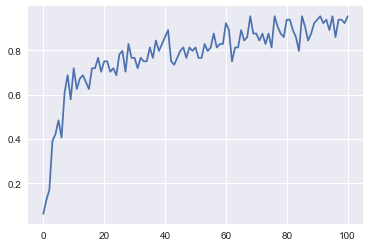

In [17]:
convolution_params = {
    'layer_1a':{'fSize':5, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':1},
    'layer_1b':{'fSize':5, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':1},
    'layer_1c':{'fSize':5, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':1},
    
    'layer_2a':{'fSize':5, 'fN':48, 'sSize':1, 'activation':'relu', 'channels':96},
    'layer_2b':{'fSize':5, 'fN':48, 'sSize':1, 'activation':'relu', 'channels':96},
    'layer_2c':{'fSize':5, 'fN':48, 'sSize':1, 'activation':'relu', 'channels':96},
    
    'layer_3':{'fSize':5, 'fN':144, 'sSize':1, 'activation':'relu', 'channels':144},
    
    'layer_4':{'fSize':5, 'fN':256, 'sSize':1, 'activation':'relu', 'channels':144}
}

fc_params = {
    'layer_1':{'nodes':500,'dropout':0.1},
    'layer_2':{'nodes':500,'dropout':0.1}
}

np.random.seed(10)
# Split the validation-set into smaller batches of this size.
validation_batch_size = 256
# Counter for total number of iterations performed so far.


total_iterations = 0
train_scores = []

setup_graph(convolution_params,fc_params)
session = tf.Session()
session.run(tf.global_variables_initializer())

optimize(num_iterations=10001) # We performed 1000 iterations above.
print_validation_accuracy()
plt.plot(train_scores)

Optimization Iteration:      1, Training Accuracy:   3.1%
Optimization Iteration:    101, Training Accuracy:  10.9%
Optimization Iteration:    201, Training Accuracy:  17.2%
Optimization Iteration:    301, Training Accuracy:  25.0%
Optimization Iteration:    401, Training Accuracy:  56.2%
Optimization Iteration:    501, Training Accuracy:  54.7%
Optimization Iteration:    601, Training Accuracy:  62.5%
Optimization Iteration:    701, Training Accuracy:  76.6%
Optimization Iteration:    801, Training Accuracy:  57.8%
Optimization Iteration:    901, Training Accuracy:  60.9%
Optimization Iteration:   1001, Training Accuracy:  59.4%
Optimization Iteration:   1101, Training Accuracy:  62.5%
Optimization Iteration:   1201, Training Accuracy:  56.2%
Optimization Iteration:   1301, Training Accuracy:  70.3%
Optimization Iteration:   1401, Training Accuracy:  68.8%
Optimization Iteration:   1501, Training Accuracy:  78.1%
Optimization Iteration:   1601, Training Accuracy:  65.6%
Optimization I

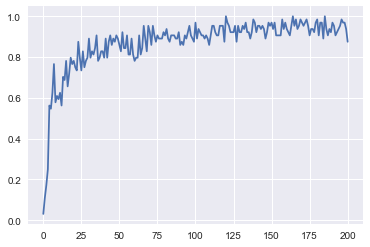

In [19]:
convolution_params = {
    'layer_1a':{'fSize':3, 'fN':16, 'sSize':1, 'activation':'relu', 'channels':1},
    'layer_1b':{'fSize':3, 'fN':16, 'sSize':1, 'activation':'relu', 'channels':1},
    'layer_1c':{'fSize':3, 'fN':16, 'sSize':1, 'activation':'relu', 'channels':1},
    
    'layer_2a':{'fSize':3, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':48},
    'layer_2b':{'fSize':3, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':48},
    'layer_2c':{'fSize':3, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':48},
    
    'layer_3':{'fSize':3, 'fN':128, 'sSize':1, 'activation':'relu', 'channels':96},
    
    'layer_4':{'fSize':3, 'fN':256, 'sSize':1, 'activation':'relu', 'channels':128}
}

fc_params = {
    'layer_1':{'nodes':500,'dropout':0.1},
    'layer_2':{'nodes':500,'dropout':0.1}
}

np.random.seed(10)
# Split the validation-set into smaller batches of this size.
validation_batch_size = 256
# Counter for total number of iterations performed so far.


total_iterations = 0
train_scores = []

setup_graph(convolution_params,fc_params)
session = tf.Session()
session.run(tf.global_variables_initializer())

optimize(num_iterations=20001) # We performed 1000 iterations above.
print_validation_accuracy()
plt.plot(train_scores)

Optimization Iteration:      1, Training Accuracy:   0.0%
Optimization Iteration:    101, Training Accuracy:  26.6%
Optimization Iteration:    201, Training Accuracy:  26.6%
Optimization Iteration:    301, Training Accuracy:  45.3%
Optimization Iteration:    401, Training Accuracy:  53.1%
Optimization Iteration:    501, Training Accuracy:  51.6%
Optimization Iteration:    601, Training Accuracy:  56.2%
Optimization Iteration:    701, Training Accuracy:  64.1%
Optimization Iteration:    801, Training Accuracy:  53.1%
Optimization Iteration:    901, Training Accuracy:  68.8%
Optimization Iteration:   1001, Training Accuracy:  62.5%
Optimization Iteration:   1101, Training Accuracy:  76.6%
Optimization Iteration:   1201, Training Accuracy:  75.0%
Optimization Iteration:   1301, Training Accuracy:  76.6%
Optimization Iteration:   1401, Training Accuracy:  78.1%
Optimization Iteration:   1501, Training Accuracy:  76.6%
Optimization Iteration:   1601, Training Accuracy:  57.8%
Optimization I

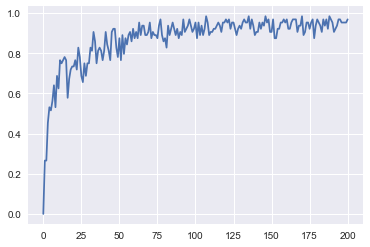

In [18]:


convolution_params = {
    'layer_1a':{'fSize':3, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':1},
    'layer_1b':{'fSize':5, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':1},
    'layer_1c':{'fSize':7, 'fN':32, 'sSize':1, 'activation':'relu', 'channels':1},
    
    'layer_2a':{'fSize':3, 'fN':64, 'sSize':1, 'activation':'relu', 'channels':96},
    'layer_2b':{'fSize':5, 'fN':64, 'sSize':1, 'activation':'relu', 'channels':96},
    'layer_2c':{'fSize':7, 'fN':64, 'sSize':1, 'activation':'relu', 'channels':96},
    
    'layer_3':{'fSize':5, 'fN':256, 'sSize':1, 'activation':'relu', 'channels':192},
    
    'layer_4':{'fSize':5, 'fN':512, 'sSize':1, 'activation':'relu', 'channels':256}
}

fc_params = {
    'layer_1':{'nodes':500,'dropout':0.1},
    'layer_2':{'nodes':500,'dropout':0.1}
}

np.random.seed(10)
# Split the validation-set into smaller batches of this size.
validation_batch_size = 256
# Counter for total number of iterations performed so far.


total_iterations = 0
train_scores = []

setup_graph(convolution_params,fc_params)
session = tf.Session()
session.run(tf.global_variables_initializer())

optimize(num_iterations=20001) # We performed 1000 iterations above.
print_validation_accuracy()
plt.plot(train_scores)

In [8]:
np.random.seed(10)
# Split the validation-set into smaller batches of this size.
validation_batch_size = 256
# Counter for total number of iterations performed so far.
total_iterations = 0
train_scores = []

# ## Performance after 10,000 optimization iterations
# 
# After 10,000 optimization iterations, the model has a classification accuracy on the validation-set of about 99%.

# In[ ]:

session = tf.Session()
session.run(tf.global_variables_initializer())

optimize(num_iterations=5001) # We performed 1000 iterations above.

print_validation_accuracy()

Optimization Iteration:      1, Training Accuracy:   0.0%
Optimization Iteration:    101, Training Accuracy:  25.0%
Optimization Iteration:    201, Training Accuracy:  25.0%
Optimization Iteration:    301, Training Accuracy:  37.5%
Optimization Iteration:    401, Training Accuracy:  37.5%
Optimization Iteration:    501, Training Accuracy:  48.4%
Optimization Iteration:    601, Training Accuracy:  39.1%
Optimization Iteration:    701, Training Accuracy:  57.8%
Optimization Iteration:    801, Training Accuracy:  70.3%
Optimization Iteration:    901, Training Accuracy:  59.4%
Optimization Iteration:   1001, Training Accuracy:  68.8%
Optimization Iteration:   1101, Training Accuracy:  59.4%
Optimization Iteration:   1201, Training Accuracy:  67.2%
Optimization Iteration:   1301, Training Accuracy:  64.1%
Optimization Iteration:   1401, Training Accuracy:  78.1%
Optimization Iteration:   1501, Training Accuracy:  64.1%
Optimization Iteration:   1601, Training Accuracy:  70.3%
Optimization I

KeyboardInterrupt: 

In [9]:
print_validation_accuracy()

Accuracy on validation-Set: 77.2% (4834 / 6262)


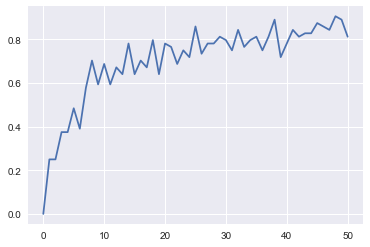

In [11]:
import seaborn as sns
%matplotlib inline
plt.plot(train_scores)

In [ ]:
optimize(num_iterations=5001) # We performed 1000 iterations above.

print_validation_accuracy()